# Hyperparameter Integration and Model Selection with GPs 

This notebook code is mostly written on top of Alan's code in ccd and loo branch. They are two different branches on Github.

In [1]:
%matplotlib inline
import numpy as np
from pylab import *
from scipy import stats

In [2]:
import GPy

In [3]:
import matplotlib.pyplot as plt
import itertools
# import seaborn as sns

Test Model Selection by integrating out hyperparameters - A short demonstration
We will use grid integration, Laplace Approximation, MCMC and CCD integration 

In [4]:
SEED = 101
np.random.seed(SEED)

## Grid Integration
Function which does grid integration which can serve as our baseline ..

In [5]:
def gridIntegration(m, rangemin, rangemax, stepsize=0.1, optimize=True):
#     make sure that m is at mode - calculate marginal likelihood at gridpoints around mode, and then sum them up.  
    if optimize:
        m.optimize()
    modal_params = m.param_array[:].copy()
    optim_params = m.optimizer_array[None,:].copy()
    param_ranges = []
    for p in optim_params[0]:
        param_ranges.append(np.arange(rangemin, rangemax, stepsize))
    grids = itertools.product(*param_ranges)
    liksum = 0
    for el in grids:
        liksum += np.exp(-m._objective(el))
    return liksum*(stepsize**len(optim_params[0]))

## Laplace Approximation
Integration by laplace Approximation - fit a gaussian at modal value given by $ m_0*(\frac{1}{2\pi})|H^{-1}|$  where $m_0$ is the marginal likelihood at the mode of hyperparameters, and H is the hessian matrix at the mode.

In [6]:
def lapIntegration(m, optimize=True):
    if optimize:
        m.optimize()
    hessian = m.numerical_parameter_hessian()
    #   calculating hessian moves the model away from the mode and we need to get back to mode.
    m.optimize()
    lap_sum = np.exp(-m._objective(m2.param_array[:]))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hessian))
    return lap_sum

###  One dimensional data
We will perform ML inference first, followed by MAP inference and then finally integration of hyperparameters using different techniques available in GPy on a simple one dimensional regression task.

Select input data and make a simple GP Regression model

In [7]:
X = np.linspace(0,5,50)[:,None]
Y = np.sin(X)*3 + np.random.randn(*X.shape)*0.4 + 0.1

Set kernel, likelihood and inference objects as RBF, Gaussian and Laplace respectively - standard GP Regression 

In [8]:
k = GPy.kern.RBF(1)
lik = GPy.likelihoods.Gaussian()
laplace = GPy.inference.latent_function_inference.Laplace()

### MLE Inference
Inference of hyperparameters in this model with Maximum Likelihood Estimation(MLE) as we have no priors for the hyperparameters. Actually GPy internally constrains the parameters to be positive, which is also a kind of prior, but just to keep things simple here, we do a simple optimisation.



In [9]:
m1 = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [10]:
m1.optimize()

In [11]:
print(m1)
print(m1.param_array[:])
print(m1.optimizer_array[:])


Name : gp
Objective : 37.5765555355
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |  priors
  rbf.variance             |   4.67611366658  |      +ve      |        
  rbf.lengthscale          |   1.46211672252  |      +ve      |        
  Gaussian_noise.variance  |  0.161892839016  |      +ve      |        
[ 4.67611367  1.46211672  0.16189284]
[ 4.66675486  1.19848287 -1.73878242]


### Set up priors here ...

We will compare two priors: a gaussian and gamma prior. We can compare these priors when we do model comparison, in the second part of the notebook.

In [12]:
gaussian_prior1 = GPy.priors.Gaussian(1.5, 0.08)
gaussian_prior2 = GPy.priors.Gaussian(1.58, 0.5)

In [13]:
gamma_prior1 = GPy.priors.Gamma.from_EV(1.5, 0.2)
gamma_prior2 = GPy.priors.Gamma.from_EV(1.5, 0.7)
# very general prior- non informative ..
gamma_prior3 = GPy.priors.Gamma.from_EV(1.0, 6.)

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/GPy/core/parameterization/priors.py:301: RuntimeWarning:invalid value encountered in log


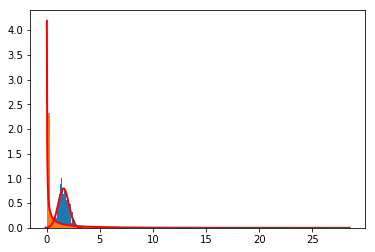

In [14]:
_= gaussian_prior2.plot()
_= gamma_prior3.plot()

In [15]:
m2 = GPy.core.GP(X.copy(), Y.copy(), k.copy(), lik.copy(), inference_method=laplace)

In [16]:
print(m1)


Name : gp
Objective : 37.5765555355
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |  priors
  rbf.variance             |   4.67611366658  |      +ve      |        
  rbf.lengthscale          |   1.46211672252  |      +ve      |        
  Gaussian_noise.variance  |  0.161892839016  |      +ve      |        


### MAP Inference
Inference of hyperparameters through MAP(Maximise aposteriori) for these models. Here we will set up a prior on the lengthscale and noise variance. The model is sensitive to the choice of priors. We will pick two priors: one with a very small width, so it is almost equivalent to ML inference, and the second prior has a wider width.
$$ p(\theta|D) \propto p(D| \theta)p(\theta) $$
$$ \log p(\theta|D) =  \log p(D| \theta) + \log p(\theta) - Constant$$
$$ \hat{\theta}, \hat{\phi} = \mathop{\mathrm{argmax}}_{\theta} p(\theta|D), \mathop{\mathrm{argmax}}_{\phi} p(\phi|D)$$
where $\theta$ represents parameters of kernel function like lengthscale, and $\phi$ represents parameters of likelihood function like variance.
### @TODO: write equations for this.


In [17]:
# m2.unconstrain()
m2.kern.lengthscale.unconstrain()
m2['.*Gaussian_noise'].unconstrain()
m2['.*variance'].unconstrain()
m2.kern.lengthscale.set_prior(gaussian_prior2)

In [18]:
print(m2[''])
m2.checkgrad()

  index  |             gp.rbf.variance  |  constraints  |    priors   
  [0]    |                  1.00000000  |               |             
  -----  |          gp.rbf.lengthscale  |  -----------  |  -----------
  [0]    |                  1.00000000  |               |  N(1.6, 0.5)
  -----  |  gp.Gaussian_noise.variance  |  -----------  |  -----------
  [0]    |                  1.00000000  |               |             


True

In [19]:
m2.optimize()

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


In [20]:
print(m2)
print(m2.log_likelihood())
# print(m2._objective())


Name : gp
Objective : 40.6563983944
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |    priors   
  rbf.variance             |   1.24370017526  |               |             
  rbf.lengthscale          |   1.20384959387  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |  0.176271946793  |               |             
-40.1476287857


In [21]:
modal_point = m2.param_array[:].copy()

In [22]:
print(m2.log_likelihood())
print(m2)

-40.1476287857

Name : gp
Objective : 40.6563983944
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |    priors   
  rbf.variance             |   1.24370017526  |               |             
  rbf.lengthscale          |   1.20384959387  |               |  N(1.6, 0.5)
  Gaussian_noise.variance  |  0.176271946793  |               |             


### Hyperparameter integration 
To take into account the full uncertainity of the hyperparameters, we need to integrate over them. We will cover this with MCMC sampling, grid integration, laplace approximation and CCD. The marginal posterior of the latent values can be  written as:

$$p(\textbf{f}|D) = \int p(\textbf{f},\theta|D)d\theta = \frac{1}{Z}\int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta $$
where $f$ is the vector of latent values, Z is the normalization constant given as $$Z = \int \int p(y|\textbf{f})p(\textbf{f}|X, \theta)p(\theta)d\theta df$$, and $D=(X,Y)$ is the set of training input and training outputs. If we change the order of integration and integrate out  $ \textbf{f}$ first, then we get an estimate of marginal likelhood, which we use for standard GP regression.

Integration over hyperparameter space is intractable, so we can use an approximation through finite sum:
 $$  p(f|D) \approx \sum_{i=1}^{M} p(\textbf{f}|D, \gamma_{i}) p(\gamma_{i}|D) \delta_{i}  $$
 where $\gamma_{i}$ represents log transformation of $\theta_{i}$ and $\delta_{i}$ is the area(voulme) weight contributed by the evaluation point in transformed hyperparameter space $\gamma_{i}$. 


### Integration with HMC

Code used from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb

In [23]:
m_hmc = GPy.core.GP(X, Y,  k.copy(), lik.copy(), inference_method=laplace)

 /u/26/dhakaa1/unix/anaconda2/envs/gpy27-devel/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


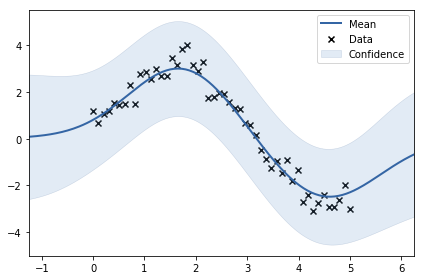

In [24]:
# m_hmc.unconstrain()
m_hmc.kern.lengthscale.set_prior(gamma_prior3)
m_hmc.kern.variance.set_prior(gamma_prior3)
m_hmc.likelihood.variance.set_prior(gamma_prior3)
_=m_hmc.plot()

Do the inference with MCMC and plot the samples 

In [25]:
hmc = GPy.inference.mcmc.HMC(m_hmc, stepsize=5e-2)
# Burnin
s = hmc.sample(num_samples=1000)
s = hmc.sample(num_samples=2000)

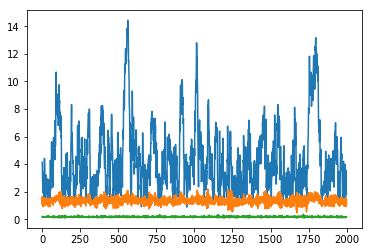

In [26]:
plot(s)

Now plot the marginal posterior distributions of model parameters:

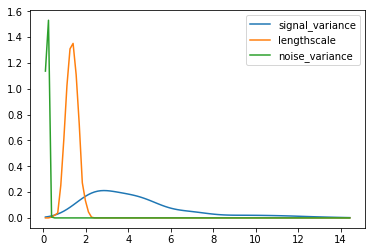

In [27]:
labels = ['signal_variance' , 'lengthscale', 'noise_variance']
# Remove burnin
samples = s[500:]
# thinning
samples = samples[::2]
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin, xmax, 100)
for i in xrange(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()


Plot the samples of lengthscale, noise variance and sigmal variance against each other two at a time.

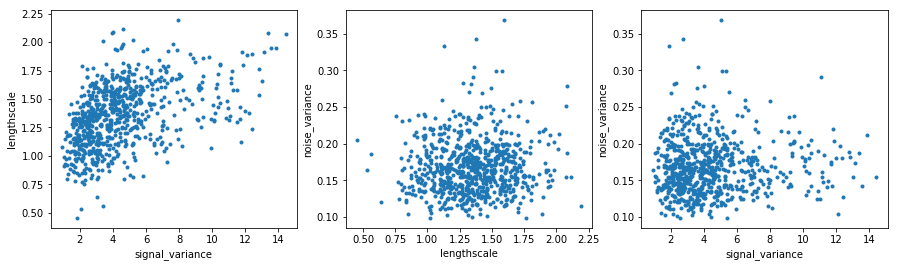

In [28]:
fig = figure(figsize=(15,4))
ax = fig.add_subplot(131)
_=ax.plot(samples[:,0],samples[:,1],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[1])
ax = fig.add_subplot(132)
_=ax.plot(samples[:,1],samples[:,2],'.')
ax.set_xlabel(labels[1]); ax.set_ylabel(labels[2])
ax = fig.add_subplot(133)
_=ax.plot(samples[:,0],samples[:,2],'.')
ax.set_xlabel(labels[0]); ax.set_ylabel(labels[2])

In [29]:
mean_values = np.mean(samples, axis=0)


Name : gp
Objective : 46.8517835035
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |           value  |  constraints  |      priors    
  rbf.variance             |    4.3879837702  |      +ve      |  Ga(0.17, 0.17)
  rbf.lengthscale          |   1.35220275045  |      +ve      |  Ga(0.17, 0.17)
  Gaussian_noise.variance  |  0.168288751469  |      +ve      |  Ga(0.17, 0.17)


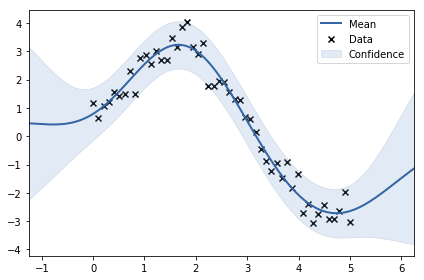

In [30]:
# set the model parameters at the posterior mean
m_hmc.kern.variance[:] = mean_values[0]
m_hmc.kern.lengthscale[:] = mean_values[1]
m_hmc.likelihood.variance[:] = mean_values[2]
print(m_hmc)
m_hmc.plot()

### Grid Integration
@TODO: Write something about grid integration 

Grid Integration is a brute force way of doing the integration over the parameter space. We use a grid of length N distributed uniformly in a D-dimensional parameter space, which will require $N^{D}$ points and hence $N^{D}$  number of evaluations. This is exponential growth. Unless N is very large, the volume covered by each grid point will become too large and thus will not really be representative of the volume, and even with so much computation power thrown at it, the results could still be poor.

Small note on Implementation details:
Be careful with the param_array and optimizer_array as they are two different entities. Optimizer_array contains only the unfixed and tranformed values, on which the actual optimizer works on, while the param_array contains all the parameter values associated with the model, the end user-(person who is doing modelling and setting up priors) sees. For example, if we put a constraint that a particular parameter should be positive, then GPy internally does a LogExp transformation to map it to optimizer space, and once optimisation is done , transforms it back to the param space with ExpLog transformation. 

In [32]:
# grid_sum = gridIntegration(m2, rangemin=0.0001, rangemax=20, stepsize=0.2)

### Laplace Integration
@TODO: Write about integration by laplace approximation.

In [34]:
lap_sum = lapIntegration(m2)

In [36]:
print  lap_sum

1.13554380299e-18


### CCD Integration
@TODO: Write about CCD Integration

In [41]:
m2.optimize()

In [42]:
m2.optimize()
# hessum = np.exp(-m2._objective(m2.param_array))*1/np.sqrt(np.linalg.det(1/(2*np.pi)*hes))         
ccdpos,ccddensity,scalings,z = m2.CCD()

The ccdpos variable gives the positions of the points, ccddenisty gives the weighted density of the CCD points, where the first point in the list is the central point. 

In [43]:
print(scalings)
# ccdpos,ccdres,scalings,z = m2.CCD()

[[ 1.          1.          1.        ]
 [ 1.51813095  1.08061285  1.19222699]
 [ 0.1         1.08061285  1.19222699]
 [ 1.51813095  0.88836499  1.19222699]
 [ 0.1         0.88836499  1.19222699]
 [ 1.51813095  1.08061285  0.79234759]
 [ 0.1         1.08061285  0.79234759]
 [ 1.51813095  0.88836499  0.79234759]
 [ 0.1         0.88836499  0.79234759]
 [ 1.51813095  1.          1.        ]
 [ 0.1         1.          1.        ]
 [ 1.          1.08061285  1.        ]
 [ 1.          0.88836499  1.        ]
 [ 1.          1.          1.19222699]
 [ 1.          1.          0.79234759]]


## Model Selection


Compare different priors with LOO score or Hyperparameter integration.

### LOO
The marginal likelihood given by integrating out latent value $\textbf{f}$ is given as :
$$ P(Y^{*}|X, \theta)$$ 
This serves as the objective for tuning the parameters of the covariance function and likelihood function. However for model selection and evaluation the LOO-CV could be considered as criterion for selection. LOO-CV is basically the predictive score for each data point y when considered in isolation as test point using the rest of the data for training. The  difference to marginal likelihood is that each point y is considered seperately. 
$$ \mathrm{LOO} = \sum_{i=1}^{N}P(y_{i}^{*}| X, Y_{-i}, \theta ) $$

Below, we compare the LOO score of the two models we considered above.

In [44]:
np.sum(m2.LOO())

-30.82631175515904

### Model Selection on Mauna-Loa dataset
Use different kernel functions sequentially and check the LOO values.

In [45]:
import pods

In [46]:
data = pods.datasets.mauna_loa()

Using cached version of the data set, to use latest version set refresh_data to True
Most recent data observation from month  7.0  in year  2017.0


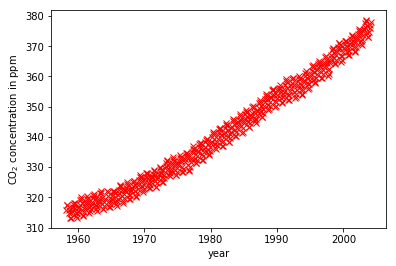

In [70]:
plt.plot(data['X'], data['Y'], 'rx')
plt.xlabel('year')
plt.ylabel('CO$_2$ concentration in ppm')

In [71]:
print(data['citation'])
print(data['info'])

Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).
Mauna Loa data with 545 values used as training points.


In [72]:
X_CO2 = data['X']
Y_CO2 = data['Y']

Make kernel object here with different components representing periodicity, seasonal and long term trends.
Use values in GPML book !!

In [73]:
k_long_term  = GPy.kern.RBF(input_dim=1, variance=66.0, lengthscale=67.0)
k_seasonal = GPy.kern.RBF(input_dim=1, variance=2.4, lengthscale=90.0)* GPy.kern.StdPeriodic(input_dim=1, lengthscale=1.3, period=1.0, active_dims=[0]) 
k_medium = GPy.kern.RatQuad(input_dim=1, variance=0.66, lengthscale=1.2, power=0.78)
k_noise = GPy.kern.RBF(input_dim=1, lengthscale=0.134, variance=0.18) + GPy.kern.White(input_dim=1, variance=0.19**2)
# k_long_term = GPy.kern.RBF(input_dim=1, variance=50.0, lengthscale=50.0)
# k_seasonal = GPy.kern.RBF(input_dim=1, variance=2.0, lengthscale=100.0) * GPy.kern.StdPeriodic(input_dim=1, lengthscale=1.3, period=1.0, active_dims=[0]) 
# k_medium = GPy.kern.RatQuad(input_dim=1, variance=0.5, lengthscale=1.0, power=1.0)
# k_noise = GPy.kern.RBF(input_dim=1, lengthscale=0.1, variance=0.1) + GPy.kern.White(input_dim=1, variance=0.1**2)
k1 = GPy.kern.RBF(1,variance=66.0, lengthscale=67.0)
k2 = GPy.kern.StdPeriodic(1, lengthscale=1.3, period=1.0) * GPy.kern.RBF(1, lengthscale=90.0, variance=2.4) 
k3 = GPy.kern.RatQuad(1,lengthscale=1.2,power=0.78, variance=0.66)
k4 = GPy.kern.RBF(1,lengthscale= 0.134, variance=0.18) + GPy.kern.White(1,variance=0.19**2)


In [74]:
Gaussian = GPy.likelihoods.Gaussian(variance=1e-3)

In [75]:
# this does not work !!
# k_all = k_long_term.copy() + k_seasonal.copy() + k_medium.copy() + k_noise.copy()

In [76]:
k_rasmussen = GPy.kern.Add([k_long_term.copy(),k_seasonal.copy(),k_medium.copy(),k_noise.copy()])
k_ras2 = GPy.kern.Add([k1.copy(),k2.copy(),k3.copy(),k4.copy()])

In [77]:
k_nonseasonal = GPy.kern.Add([k_long_term.copy(),k_medium.copy(),k_noise.copy()])

In [78]:
k_non_longterm = GPy.kern.Add([k_seasonal.copy(),k_medium.copy(),k_noise.copy()])

First model with all kernels and then remove them one by one.

In [79]:
m_co2_rasmus = GPy.core.GP(X_CO2, Y_CO2, kernel=k_ras2, likelihood=Gaussian.copy(), inference_method=laplace)

In [80]:
m_co2_rasmus.optimize()

In [81]:
print(m_co2_rasmus[''])

  index  |                  gp.sum.rbf.variance  |  constraints  |  priors
  [0]    |                          66.00000382  |      +ve      |        
  -----  |               gp.sum.rbf.lengthscale  |  -----------  |  ------
  [0]    |                          67.00000112  |      +ve      |        
  -----  |     gp.sum.mul.std_periodic.variance  |  -----------  |  ------
  [0]    |                           1.00000721  |      +ve      |        
  -----  |       gp.sum.mul.std_periodic.period  |  -----------  |  ------
  [0]    |                           0.99967914  |      +ve      |        
  -----  |  gp.sum.mul.std_periodic.lengthscale  |  -----------  |  ------
  [0]    |                           1.29998834  |      +ve      |        
  -----  |              gp.sum.mul.rbf.variance  |  -----------  |  ------
  [0]    |                           2.40000621  |      +ve      |        
  -----  |           gp.sum.mul.rbf.lengthscale  |  -----------  |  ------
  [0]    |               

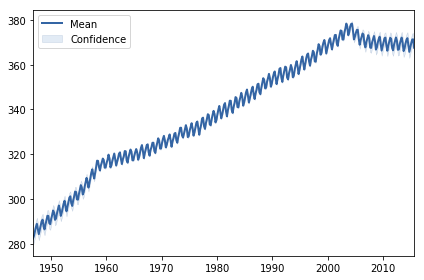

In [83]:
m_co2_rasmus.plot(plot_raw=True, resolution=400)

## References
1. Jarno Vanhatalo, Ville Pietiläinen, and Aki Vehtari. 2010. Approximate inference
for disease mapping with sparse Gaussian processes. Statistics in Medicine,
volume 29, number 15, pages 1580-1607.

2.Rue, Håvard, Sara Martino, and Nicolas Chopin. "Approximate Bayesian inference for latent Gaussian models by using integrated nested Laplace approximations." Journal of the royal statistical society: Series b (statistical methodology) 71.2 (2009): 319-392. http://www.jstor.org/stable/40247579
